In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
#INDUS: proportion of non-retail business acres per town
#CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#NOX: nitric oxides concentration (parts per 10 million)
#RM: average number of rooms per dwelling
#AGE: proportion of owner-occupied units built prior to 1940
#DIS: weighted distances to ﬁve Boston employment centers
#RAD: index of accessibility to radial highways
#TAX: full-value property-tax rate per $10,000
#PTRATIO: pupil-teacher ratio by town 12. 
#B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 13. 
#LSTAT: % lower status of the population
#MEDV: Median value of owner-occupied homes in $1000s

In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("boston.csv", header=None, delimiter=r"\s+", names=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
import math

def plot_all_histograms(df, title_prefix=""):
    num_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = math.ceil(len(num_cols) / n_cols)

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"{title_prefix}{col}")
        plt.xlabel("")
        plt.ylabel("")

    plt.tight_layout()
    plt.show()

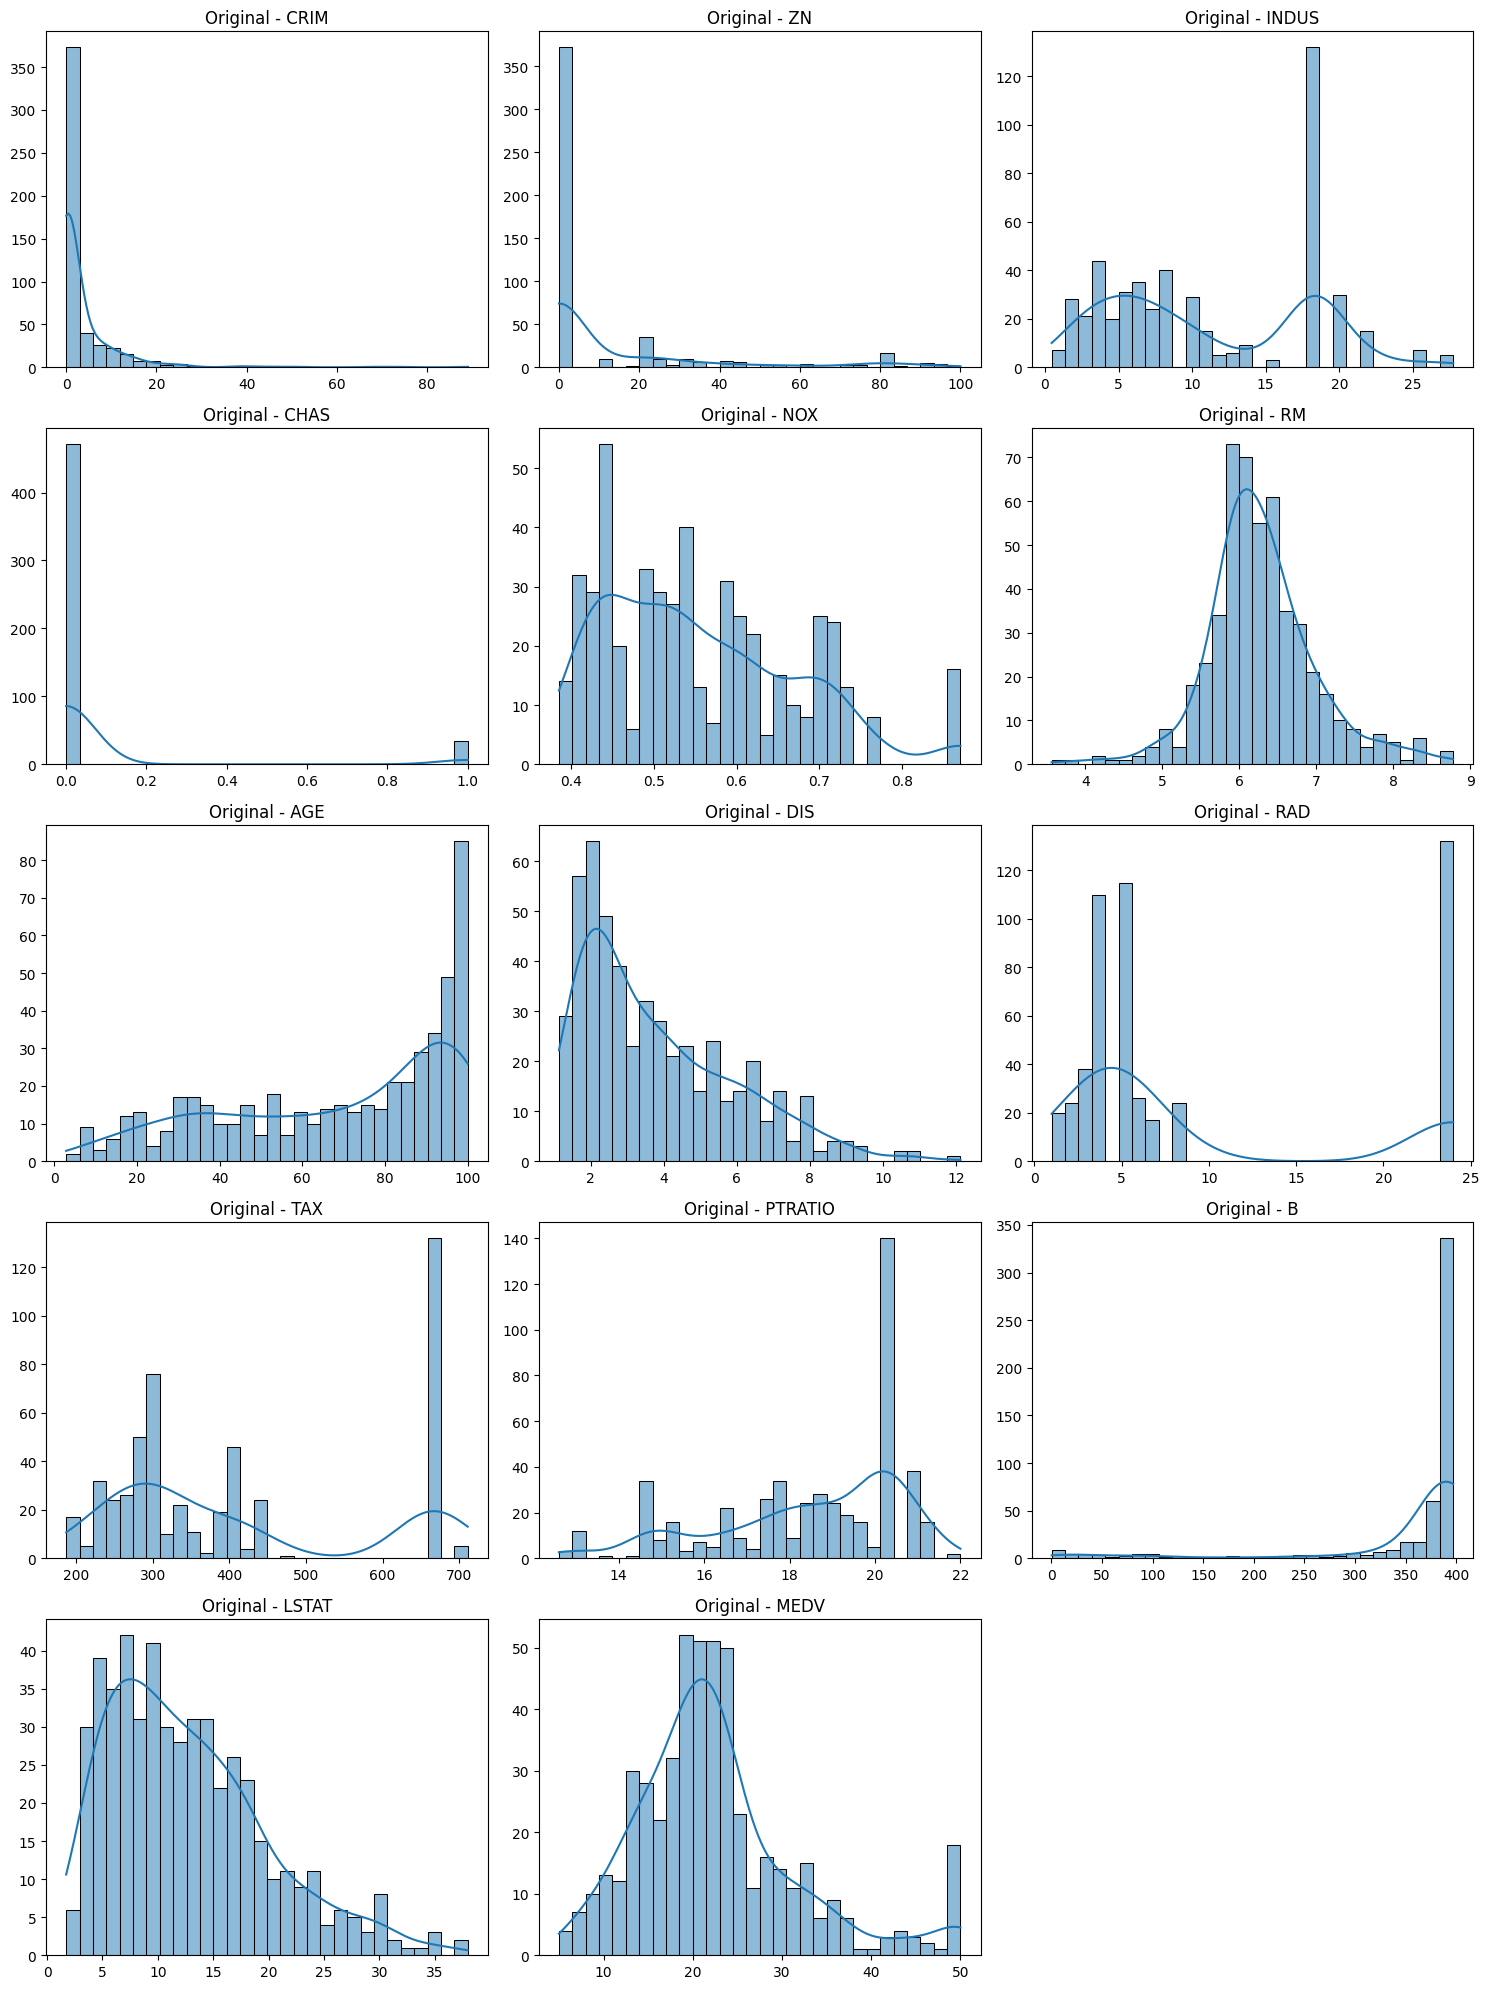

In [6]:
plot_all_histograms(df, title_prefix="Original - ")

In [7]:
from scipy.stats import skew
skews = df.apply(skew).sort_values(ascending=False)
print(skews)

CRIM       5.207652
CHAS       3.395799
ZN         2.219063
MEDV       1.104811
DIS        1.008779
RAD        1.001833
LSTAT      0.903771
NOX        0.727144
TAX        0.667968
RM         0.402415
INDUS      0.294146
AGE       -0.597186
PTRATIO   -0.799945
B         -2.881798
dtype: float64


In [8]:
from sklearn.preprocessing import PowerTransformer
X = df.drop('MEDV', axis=1)
y = df["MEDV"]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
pt_X = PowerTransformer(method="yeo-johnson")

X_train_transformed = pt_X.fit_transform(X_train)
X_test_transformed = pt_X.transform(X_test)

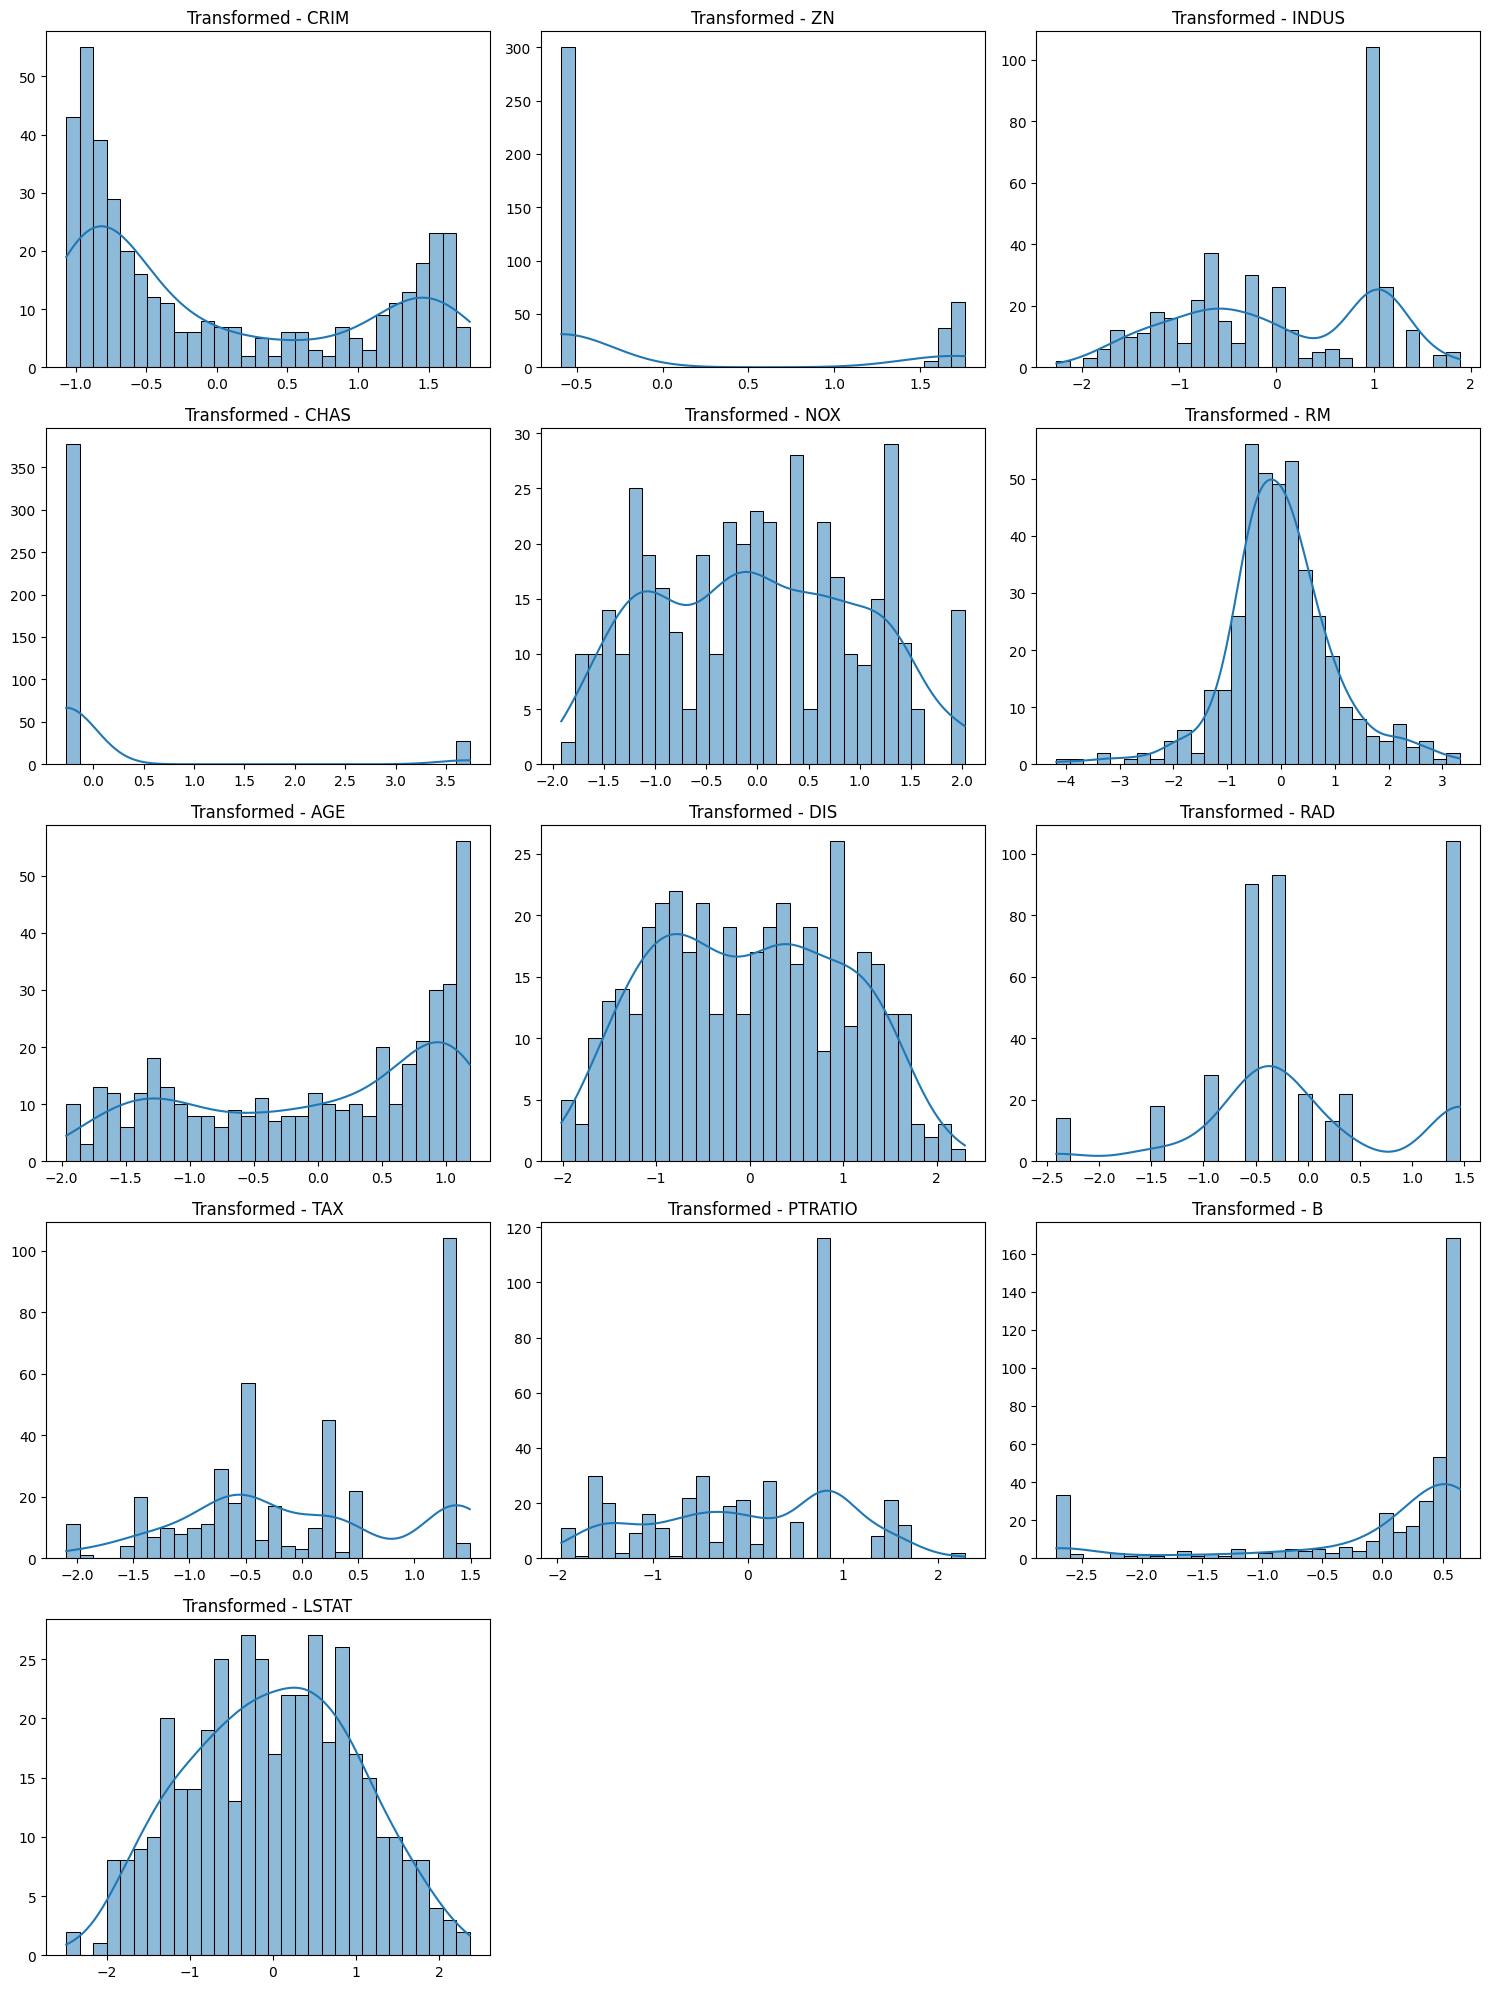

In [10]:
# let's try to create a df out of X_train_transformed to see if we can compare histograms
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns = column_names)
plot_all_histograms(X_train_transformed_df, title_prefix="Transformed - ")

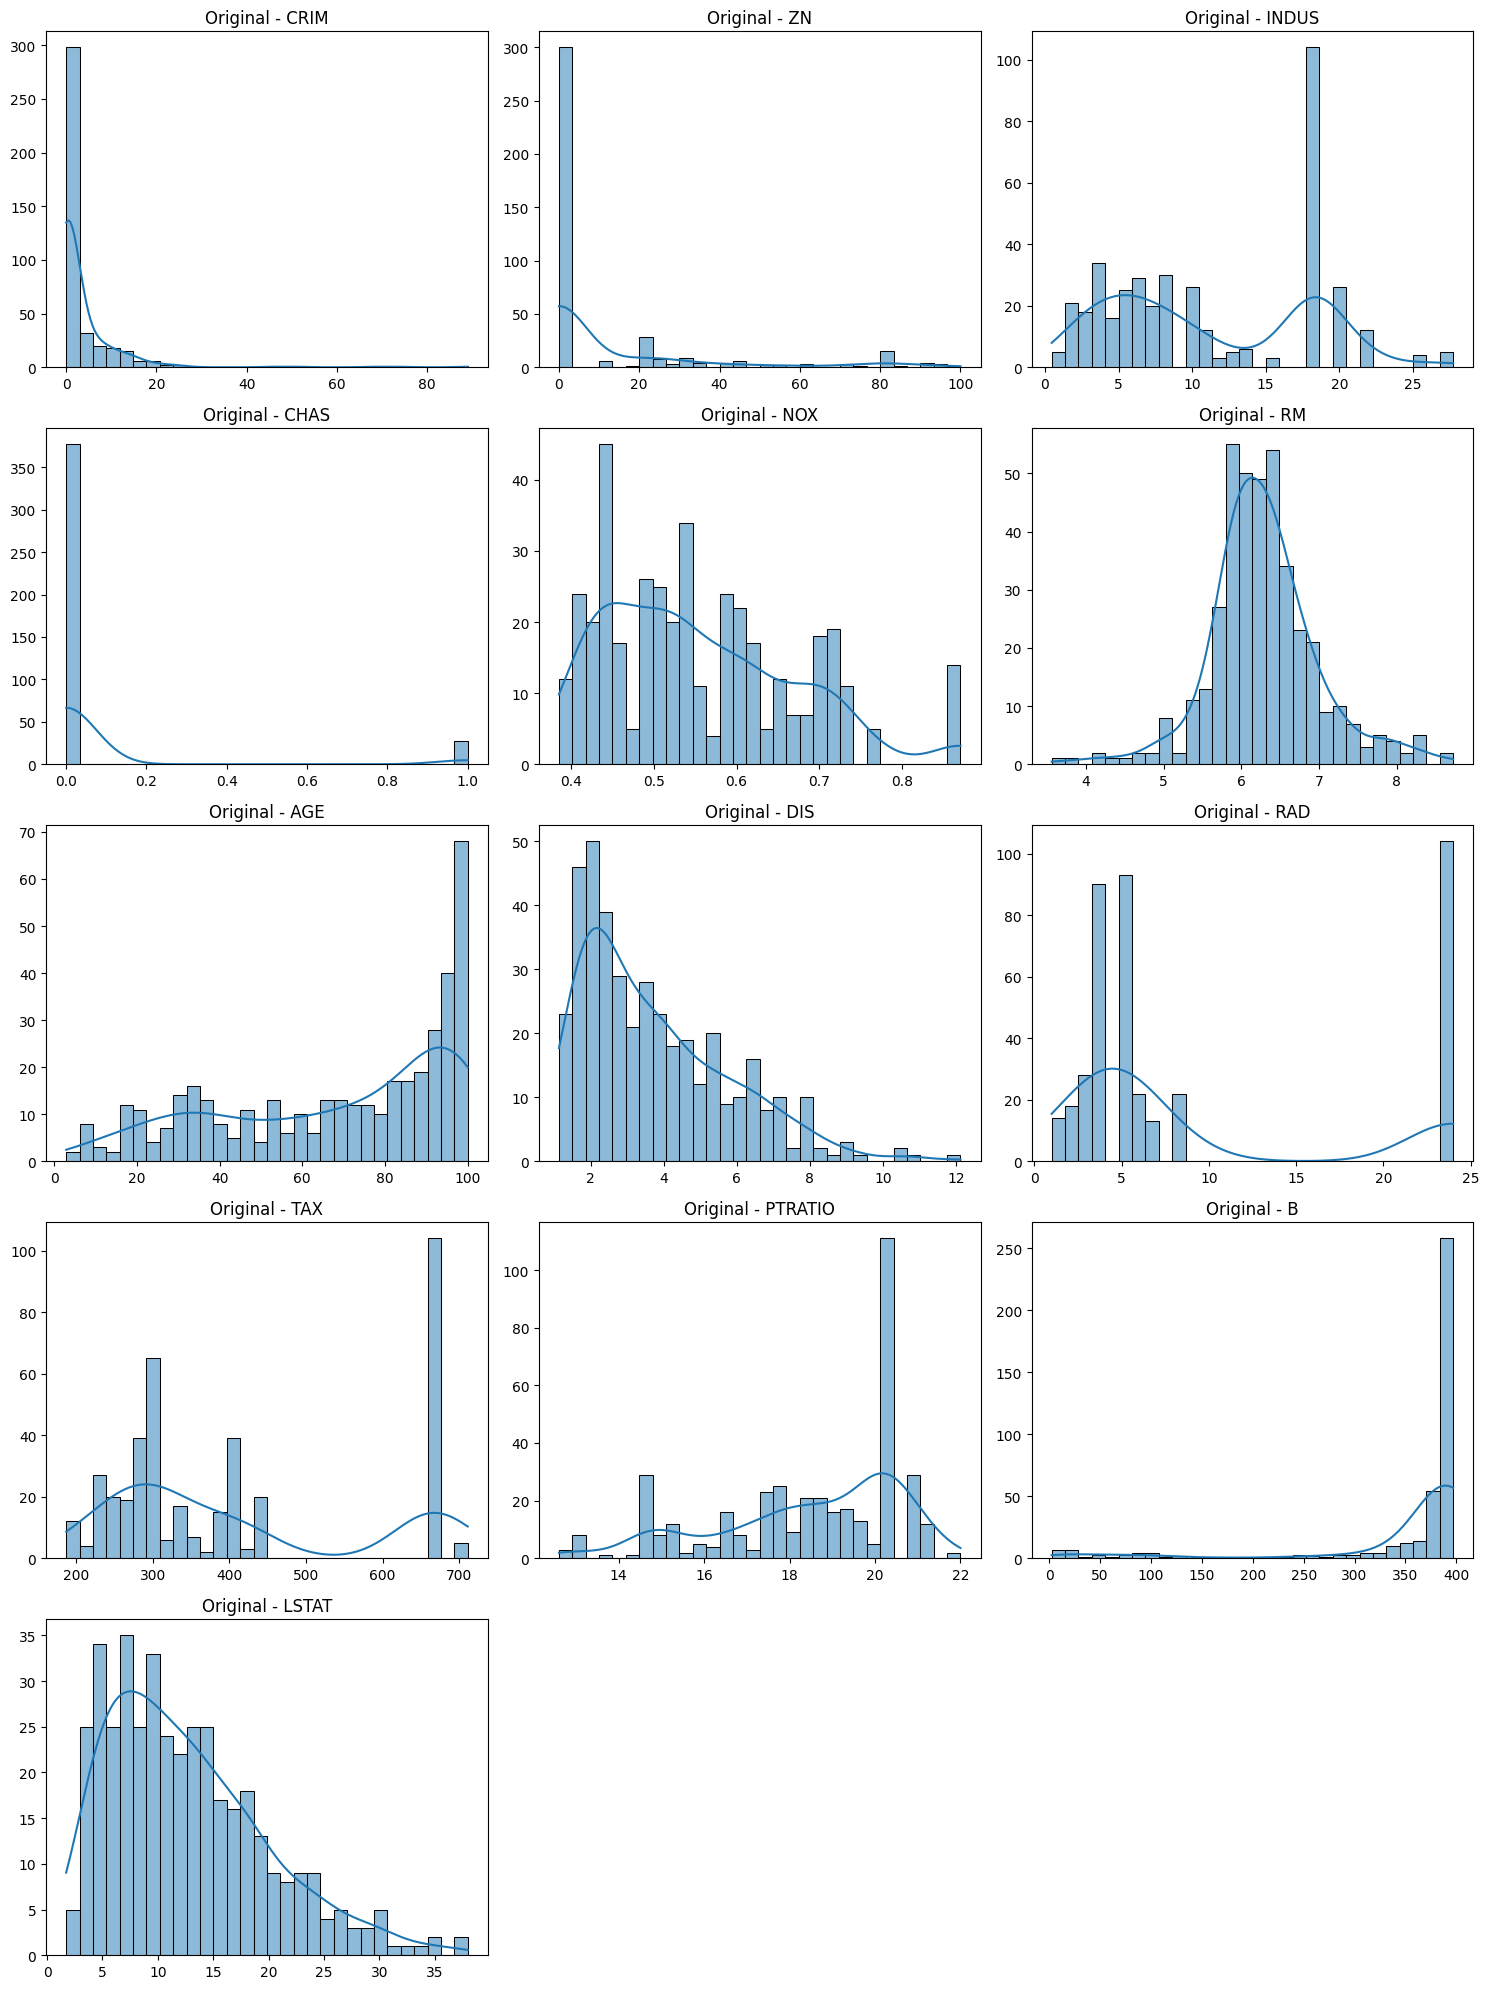

In [11]:
plot_all_histograms(X_train, title_prefix="Original - ")

In [12]:
from scipy.stats import boxcox

# we cannot execute power transformer on y, because power transformer expects a 2d array, 
# we have a series here. so i will use boxcox from scipy
y_train_transformed, lambda_y = boxcox(y_train)

In [13]:
# i want to keep it simple to see the affect of transformations
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_transformed, y_train_transformed)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [14]:
y_pred_transformed = model.predict(X_test_transformed)

# (inverse Box-Cox)
def inverse_boxcox(y, lambda_):
    if lambda_ == 0:
        return np.exp(y)
    else:
        return np.power(y * lambda_ + 1, 1 / lambda_)

# original scaling of predictions
y_pred_original = inverse_boxcox(y_pred_transformed, lambda_y)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
print("R2 Score:", r2_score(y_test, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_original)))

R2 Score: 0.7755639708985015
RMSE: 4.166044654023118


In [16]:
# let's do without transformation
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.6920749038652134
RMSE: 4.8797792434782075
